In [1]:
import torch
import torch.nn as nn
import torchvision.models as models

import glob
import tqdm
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import time
import tqdm 
import copy
from IPython.display import display, Image, clear_output
from tqdm import tqdm_notebook as tqdmn


In [2]:
camera_index = 0

cap = cv2.VideoCapture(camera_index, cv2.CAP_DSHOW) # this is the magic!


In [3]:

def plot_img(img,c='red'):
    # plt.imshow(img.transpose(1,0,2))
    cv2.imshow('a', cv2.cvtColor(img.transpose(1,0,2), cv2.COLOR_RGB2BGR))
    cv2.waitKey(1)

In [4]:

secondary_screen_width, secondary_screen_height = 660, 330 
scale = 1

pattern = np.zeros((secondary_screen_width//scale, secondary_screen_height//scale,3),dtype=np.uint8) 


jumps = 10

width = 2

In [33]:
frames = []
clear_output()
pbar = tqdm.tqdm(total=(secondary_screen_width//scale//jumps)*(secondary_screen_height//scale//jumps), desc='Generating patterns')

for i in range(0,secondary_screen_width//scale,jumps):
    for j in range(0,secondary_screen_height//scale,jumps):
        pattern = np.zeros((secondary_screen_width//scale, secondary_screen_height//scale,3),dtype=np.uint8)
        pattern[i:i+width,:] = 255
        pattern[:,j:j+width] = 255
        plot_img(pattern)
        time.sleep(0.1)


        for k in range(5):
            ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
        else:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

        pbar.update(1)


Finding cross points: 100%|██████████| 2178/2178 [01:08<00:00, 31.80it/s]


In [ ]:
# # save frames to pickle
import pickle
# with open('frames.pkl', 'wb') as f:
#     pickle.dump(frames, f)
# with open('frames.pkl', 'rb') as f:
#     frames = pickle.load(f)

In [34]:
pattern = np.zeros((secondary_screen_width//scale, secondary_screen_height//scale,3),dtype=np.uint8)
plot_img(pattern,'black')

for k in range(5):
    ret, frame = cap.read()
if not ret:
    print("Failed to grab frame")
else:
    base_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
base_frame = base_frame / 255.0


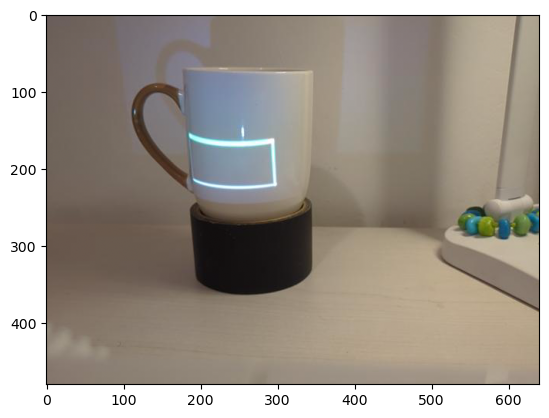

In [36]:
plt.imshow(base_frame)

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image

def cross_point(d):
    img = (d.clip(0,1) * 255).astype(np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = gray>50
    gray = gray.astype(np.uint8) * 100
    # Enhance contrast
    # gray = cv2.equalizeHist(gray)

    # Edge detection
    # edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Detect lines using Hough Transform
    lines = cv2.HoughLines(gray, 1, np.pi / 180, threshold=1)

    thr = 100
    lines_vert = []
    lines_horz = []

    while len(lines_vert) < 1 or len(lines_horz) < 1:
        lines = cv2.HoughLines(gray, 1, np.pi / 180, threshold=thr)
        if lines is not None:    
            for rho, theta in lines[:,0]:
                a = np.cos(theta)
                b = np.sin(theta)
                if abs(a) > abs(b):
                    lines_vert.append((rho,theta))
                else:
                    lines_horz.append((rho,theta))
        thr -= 5

        if thr < 30:
            return img, None


    # Convert polar coords to line equations and find intersection
    def get_line_params(rho, theta):
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        return pt1, pt2

    def line_intersection(p1, p2, p3, p4):
        """Return intersection point of lines (p1,p2) and (p3,p4)"""
        x1,y1 = p1
        x2,y2 = p2
        x3,y3 = p3
        x4,y4 = p4

        denom = (x1-x2)*(y3-y4) - (y1-y2)*(x3-x4)
        if denom == 0:
            return None  # parallel lines

        px = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4)) / denom
        py = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4)) / denom
        return int(px), int(py)

    # We'll store the first two lines only
    line_points = []

    rho, theta = lines_vert[0]
    p1, p2 = get_line_params(rho, theta)
    line_points.append((p1, p2))
    cv2.line(img, p1, p2, (0, 0, 255), 2)

    rho, theta = lines_horz[0]
    p1, p2 = get_line_params(rho, theta)
    line_points.append((p1, p2))
    cv2.line(img, p1, p2, (0, 0, 255), 2)
    pt = line_intersection(*line_points[0], *line_points[1])
    cv2.circle(img, pt, 7, (0, 255, 0), -1)
    
    return img, pt


length = 10   # total length of the cross arms
thickness = 2 # how thick each line is (set 1 or 2 if you want thicker lines)

# Create empty kernel
kernel_size = (length, length)
kernel = np.zeros(kernel_size)

center = length // 2

# Set horizontal line
kernel[center - thickness//2 : center + thickness//2 + 1, center - thickness//2:] = 1

# Set vertical line
kernel[center - thickness//2:, center - thickness//2 : center + thickness//2 + 1] = 1

upper_left = kernel
lower_left = np.rot90(kernel,1)
lower_right = np.rot90(kernel,2)
upper_right = np.rot90(kernel,3)
# kernel = kernel / np.sum(kernel)

# kernel = np.array([
#     [0, 0, 1, 1, 1, 0, 0],
#     [0, 0, 1, 1, 1, 0, 0],
#     [1, 1, 1, 1, 1, 1, 1],
#     [1, 1, 1, 1, 1, 1, 1],
#     [1, 1, 1, 1, 1, 1, 1],
#     [0, 0, 1, 1, 1, 0, 0],
#     [0, 0, 1, 1, 1, 0, 0]
# ], dtype=np.float32)
# kernel = kernel*2 - 1
# kernel = kernel / np.sum(kernel)

def find_cross_ker(d):

    img = (d.clip(0,1) * 255).astype(np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = gray>50
    gray = gray.astype(np.uint8) 

    gray = gray - gray.mean()
    # Apply the filter (cross-correlation)
    candidates = []
    for ker in [upper_left, lower_left, lower_right, upper_right]:
        filtered = cv2.filter2D(gray, -1, ker)
        minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(filtered)
        center_x, center_y = maxLoc
        candidates.append((maxVal, center_x, center_y))

    best = max(candidates, key=lambda x: x[0])
    maxVal, center_x, center_y = best

    if maxVal < 20:
        # print('maxVal', maxVal, 'is too low')
        return img, None
    cv2.circle(img, (center_x, center_y), 7, (0, 255, 0), -1)
    return  img, (center_x, center_y)

def helper(frame):
    return cross_point(frame/255.0 - base_frame)

def helper2(frame):
    return find_cross_ker(frame/255.0 - base_frame)

In [38]:
from multiprocessing.dummy import Pool


In [39]:
with Pool(4) as pool:
    # Use tqdm to wrap the map function
    # This will show a progress bar
    res = list(tqdm.tqdm_notebook(pool.imap(helper2, frames), total=len(frames)))

C:\Users\danny\AppData\Local\Temp\ipykernel_16724\1121963683.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  res = list(tqdm.tqdm_notebook(pool.imap(helper2, frames), total=len(frames)))


  0%|          | 0/2178 [00:00<?, ?it/s]

In [40]:
# with Pool(4) as pool:
#     # Use tqdm to wrap the map function
#     # This will show a progress bar
#     res2 = list(tqdm.tqdm_notebook(pool.imap(helper, frames), total=len(frames)))

In [41]:
clear_output()
clear_output()

f = 0
points = []
new_points = []
imgs = []
not_found = []
burned = []
pbar = tqdm.tqdm(total=(secondary_screen_width//scale//jumps)*(secondary_screen_height//scale//jumps), desc='Finding cross points')
for i in range(0,secondary_screen_width//scale,jumps):
    for j in range(0,secondary_screen_height//scale,jumps):
        # d = frames[f]/255.0-base_frame
        # cp = cross_point(d)
        cp = res[f]
        # if cp[1] is None:
        #     cp = res2[f]
        pos = cp[1]
        imgs.append(cp[0])
        if pos is None:
            not_found.append(f)
        else:
            if pos[0] > 0 and pos[1] > 0:
                points.append((i,j))
                new_points.append(pos)
                
            else:  
                burned.append(f)
        f+=1
        pbar.update(1)

Generating patterns: 100%|██████████| 2178/2178 [09:47<00:00,  3.71it/s]


In [42]:
positions = [(orig,n) for orig,n in zip(points,new_points) if n is not None]


In [43]:

original_points = np.array([x[0] for x in positions])
new_points = np.array([x[1] for x in positions])

mean_x,std_x = np.mean(new_points[:,0]), np.std(new_points[:,0])
mean_y,std_y = np.mean(new_points[:,1]), np.std(new_points[:,1])
# remove outliers from new_points
slack =3
new_points_clear = new_points[ (np.abs(new_points[:,0]-mean_x)<slack*std_x) & (np.abs(new_points[:,1]-mean_y)<slack*std_y) ]
original_points = original_points[ (np.abs(new_points[:,0]-mean_x)<slack*std_x) & (np.abs(new_points[:,1]-mean_y)<slack*std_y) ]

H, _ = cv2.findHomography(original_points.astype(np.float64), new_points_clear.astype(np.float64), cv2.RANSAC )


# Warp original points
warped_points_pred = cv2.perspectiveTransform(original_points.reshape(-1, 1, 2).astype(np.float64), H)


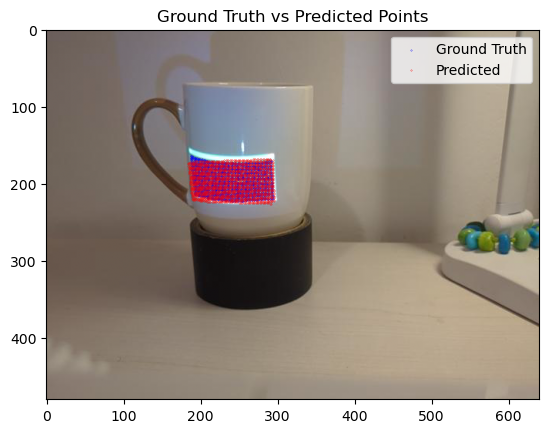

In [45]:
plt.imshow(base_frame)
plt.scatter(new_points_clear[:, 0], new_points_clear[:, 1], c='blue', label='Ground Truth', s=0.05)
# plt.scatter(new_points_sampled[:, 0], new_points_sampled[:, 1], c='blue', label='Ground Truth', s=0.05)
plt.scatter(warped_points_pred[:, 0, 0], warped_points_pred[:, 0, 1], c='red', label='Predicted', s=0.05)
plt.legend()
plt.title('Ground Truth vs Predicted Points')
plt.show()

In [49]:
import glob
# decoded_latents_path = glob.glob('current_pairs/adv_patch_*.jpg')
decoded_latents_path = glob.glob('botorch_snapshots//*patch*')


In [50]:
decoded_latents_path[:100]

['botorch_snapshots\\04-05_21_30_34_patch.jpg',
 'botorch_snapshots\\04-05_21_30_35_patch.jpg',
 'botorch_snapshots\\04-05_21_30_36_patch.jpg',
 'botorch_snapshots\\04-05_21_30_37_patch.jpg',
 'botorch_snapshots\\04-05_21_30_38_patch.jpg',
 'botorch_snapshots\\04-05_21_30_39_patch.jpg',
 'botorch_snapshots\\04-05_21_30_41_patch.jpg',
 'botorch_snapshots\\04-05_21_30_42_patch.jpg',
 'botorch_snapshots\\04-05_21_30_43_patch.jpg',
 'botorch_snapshots\\04-05_21_30_44_patch.jpg',
 'botorch_snapshots\\04-05_21_31_01_patch.jpg',
 'botorch_snapshots\\04-05_21_31_02_patch.jpg',
 'botorch_snapshots\\04-05_21_31_04_patch.jpg',
 'botorch_snapshots\\04-05_21_31_05_patch.jpg',
 'botorch_snapshots\\04-05_21_31_06_patch.jpg',
 'botorch_snapshots\\04-05_21_31_07_patch.jpg',
 'botorch_snapshots\\04-05_21_31_08_patch.jpg',
 'botorch_snapshots\\04-05_21_31_09_patch.jpg',
 'botorch_snapshots\\04-05_21_31_10_patch.jpg',
 'botorch_snapshots\\04-05_21_31_11_patch.jpg',
 'botorch_snapshots\\04-05_21_31_19_patc

In [51]:
len(decoded_latents_path)

6375

In [52]:
import torchvision
resizer =  torchvision.transforms.Resize((330, 660))
tt = torchvision.transforms.ToTensor()


In [53]:
# decoded_latents = []
# for path in decoded_latents_path:
#     img = cv2.imread(path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     # img = img / 255.0
#     decoded_latents.append(img)

In [71]:
frames_patchs = []
adv_patchs = []

for adv_patch in tqdm.tqdm_notebook(decoded_latents_path):

    if type(adv_patch) == str:
            adv_patch = cv2.imread(adv_patch)
            adv_patch = cv2.cvtColor(adv_patch, cv2.COLOR_BGR2RGB)
    # break
    adv_patch= (resizer(tt(adv_patch)).permute(1,2,0).numpy() * 255.0).astype(np.uint8)
    cv2.imshow('a',cv2.cvtColor(adv_patch, cv2.COLOR_RGB2BGR))
    cv2.waitKey(1)
    time.sleep(1)
    for ww in range(3):
        ret, frame = cap.read()
    if not ret:
        raise
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    if len(frames) != 0 and (frame != frames[-1]).sum() == 0:
        print('same frame')
        raise

    cv2.destroyAllWindows()

    frames_patchs.append(frame)
    adv_patchs.append(adv_patch)


C:\Users\danny\AppData\Local\Temp\ipykernel_16724\1275126781.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for adv_patch in tqdm.tqdm_notebook(decoded_latents_path):


  0%|          | 0/6375 [00:00<?, ?it/s]

In [913]:
# save all frames_patchs as jpgs
os.makedirs('frames_patchs', exist_ok=True)
for i, frame in tqdm.tqdm(enumerate(frames_patchs)):
    cv2.imwrite(f'frames_patchs/frame_{i}.jpg', cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

6375it [00:34, 183.09it/s]


In [90]:
cv2.destroyAllWindows()
time.sleep(3)
for k in range(5):
    ret, frame = cap.read()
if not ret:
    print("Failed to grab frame")
else:
    orig_ref_frame_for_saving = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    

In [26]:
import pickle
from torchvision import transforms
import matplotlib.pyplot as plt
tt = transforms.ToTensor()
# load data from calibration
# with open('./calibration_dump/calibration4.pickle','rb') as f:
#     H = pickle.load(f)
# with open('./calibration_dump/orig_ref_frame4.pickle','rb') as f:
#     orig_ref_frame = pickle.load(f)

from torchvision import transforms

tt = transforms.ToTensor()

import torch 
import kornia
H_t = torch.tensor(H).float().unsqueeze(0).cpu()
def warp(img):
    return kornia.geometry.transform.warp_perspective(img, H_t, (orig_ref_frame_for_saving.shape[0], orig_ref_frame_for_saving.shape[1]))


H_t_i = H_t.inverse()
def unwarp(img):
    return kornia.geometry.transform.warp_perspective(img, H_t_i , (330,660))

In [113]:
unwrapped_frames = []
with torch.no_grad():
    for frame in tqdm.tqdm_notebook(frames_patchs):
        frame_tensor = torch.tensor(frame).permute(2,0,1).float().cpu().unsqueeze(0) / 255
        unwrapped_frame = unwarp(frame_tensor).squeeze(0).cpu()
        unwrapped_frames.append(unwrapped_frame)


C:\Users\danny\AppData\Local\Temp\ipykernel_26632\2365077351.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for frame in tqdm.tqdm_notebook(frames_patchs):


  0%|          | 0/6375 [00:00<?, ?it/s]

In [ ]:

for i in tqdm.tqdm_notebook(range(len(unwrapped_frames))):
    unwrapped_frame = unwrapped_frames[i].cpu().numpy().transpose(1,2,0)
    unwrapped_frame = (unwrapped_frame * 255).astype(np.uint8)
    unwrapped_frame = cv2.cvtColor(unwrapped_frame, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f'botorch_snapshots//unwrapped_frame_mug_27_4_{i}.jpg',unwrapped_frame)

C:\Users\danny\AppData\Local\Temp\ipykernel_26632\267232060.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(len(unwrapped_frames))):


  0%|          | 0/6375 [00:00<?, ?it/s]

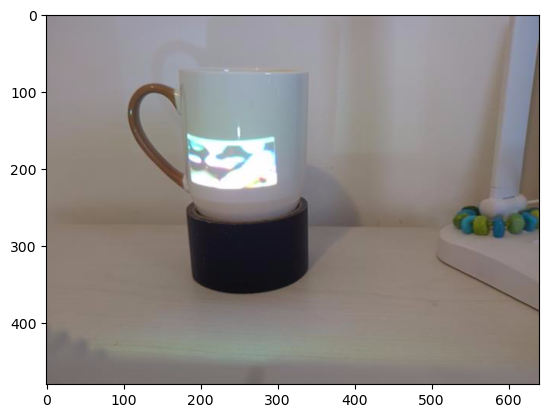

In [44]:
plt.imshow(frames_patchs[10])

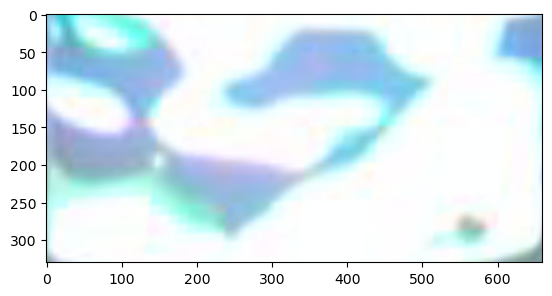

In [116]:
plt.imshow(unwarp(tt(frames_patchs[10]).unsqueeze(0).cpu()).cpu().permute(0,2,3,1).squeeze(0).numpy())

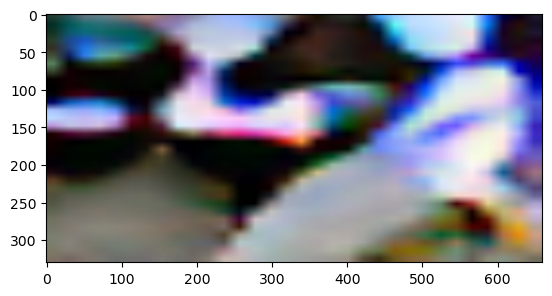

In [117]:
plt.imshow(adv_patchs[10])

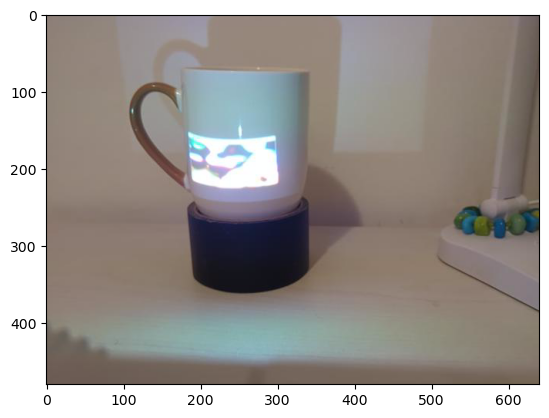

In [41]:
plt.imshow(frames_patchs[10])

In [91]:
import pickle
dump_dir = './dump_for_train/'
with open(dump_dir + 'orig_ref_frame.pickle','wb') as f:
    pickle.dump(orig_ref_frame_for_saving,f)


In [93]:

with open(dump_dir + 'H.pickle','wb') as f:
    pickle.dump(H,f)


In [74]:
from utils.classfier import *


In [100]:
im_load = cv2.imread('./patches/out_22_4_1.png')

im_load_m = cv2.imread('./patches/out_22_4_m_1.png')
im = cv2.cvtColor(im_load, cv2.COLOR_BGR2RGB)

cv2.imshow('a', im)

predicted = []
cv2.waitKey(1)
for i in range(100):
    time.sleep(0.5)
    for ww in range(7):
        ret, frame = cap.read()
    if not ret:
        raise
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame)
    plt.show()
    

    frame_tensor = torch.tensor(frame.transpose(2,0,1)).float().cuda().unsqueeze(0) / 255 
    with torch.no_grad():
        p = resnet_predict(frame_tensor)
        print(p)
    predicted.append(p)
    time.sleep(0.5)
    clear_output()

cv2.destroyAllWindows()

KeyboardInterrupt: 

In [102]:
import pandas as pd

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


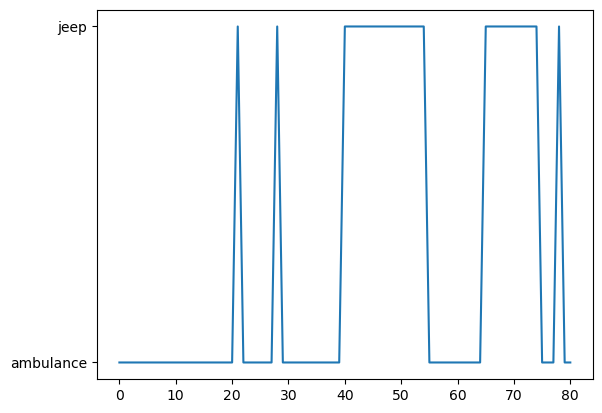

In [109]:
plt.plot([x.split(' ')[0][:-1] for x in predicted],)

(array([6.54320988, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 3.45679012]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

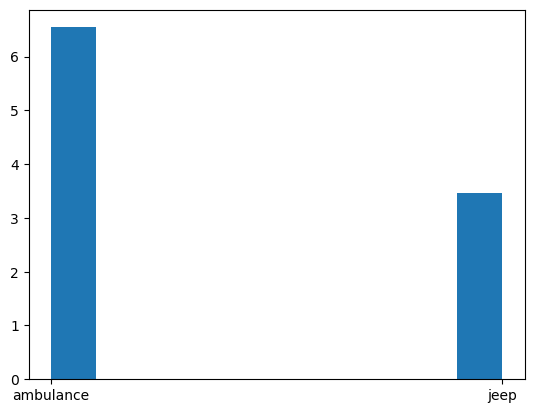

In [ ]:
plt.hist([x.split(' ')[0][:-1] for x in predicted],)

In [104]:
pd.DataFrame([x.split(' ')[0] for x in predicted]).hist()

ValueError: hist method requires numerical or datetime columns, nothing to plot.

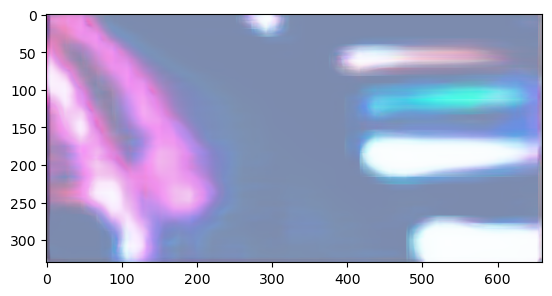

In [88]:
plt.imshow(im_load_m)

C:\Users\danny\AppData\Local\Temp\ipykernel_16724\1535359889.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_masked = unwarped_frame * torch.tensor(img_section_mask)


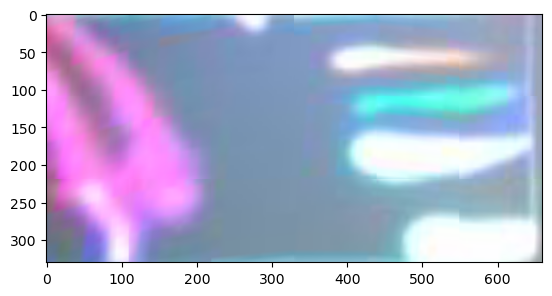

In [89]:
plt.imshow(unwarp2(frame_tensor.cpu()).squeeze(0).cpu().permute(1,2,0).numpy())

In [906]:
cv2.destroyAllWindows()

# TPS

In [1033]:
x_sec_orig.shape

(66,)

In [1042]:
x_sec_orig.shape

(66,)

In [1205]:
np.arange(0,331,30)

array([  0,  30,  60,  90, 120, 150, 180, 210, 240, 270, 300, 330])

In [1212]:
y_sec

array([  0,  40,  80, 120, 160, 200, 240, 280, 320])

In [1224]:
660/120

5.5

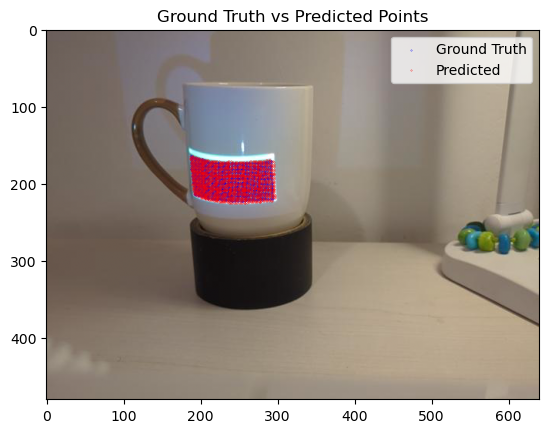

In [48]:
x_sec_orig = np.sort(np.unique((original_points[:,0])))
y_sec_orig = np.sort(np.unique((original_points[:,1])))



num_sections = 5

x_sec = np.arange(0,661,110)#x_sec_orig[::13]#len(x_sec_orig)//num_sections]
y_sec = np.arange(0,331,110)#y_sec_orig[::4]#len(y_sec_orig)//num_sections]

# x_sec = np.concatenate((x_sec,[x_sec_orig[-1]]))
# y_sec = np.concatenate((y_sec, [y_sec_orig[-1]]))



orig_points_cat = []
new_points_cat = []
preds =[]
Hs = []
sections = []
target_sections = []

buffer = 3
for i in range(len(x_sec)-1):
    for j in range(len(y_sec)-1):
        start_x = int(x_sec[i]) - buffer
        start_y = int(y_sec[j]) - buffer
        end_x = int(x_sec[i+1]) + buffer
        end_y = int(y_sec[j+1]) + buffer
        original_points_in_section_mask =  (original_points[:,0] > start_x) & (original_points[:,0] < end_x) & (original_points[:,1] > start_y) & (original_points[:,1] < end_y)
        original_points_in_section = original_points[original_points_in_section_mask]
        new_points_in_section = new_points_clear[original_points_in_section_mask]

        H, _ = cv2.findHomography(original_points_in_section.astype(np.float64), new_points_in_section.astype(np.float64), cv2.RANSAC )
        Hs.append(H)

        pred = cv2.perspectiveTransform(original_points_in_section.reshape(-1, 1, 2).astype(np.float64), H)
        new_points_cat.append(new_points_in_section)
        orig_points_cat.append(original_points_in_section)
        preds.append(pred)
        sections.append((start_x, start_y, end_x, end_y))

        target_start_x = new_points_in_section[:,0].min()
        target_start_y = new_points_in_section[:,1].min()
        target_end_x = new_points_in_section[:,0].max()
        target_end_y = new_points_in_section[:,1].max()
        target_sections.append((target_start_x, target_start_y, target_end_x, target_end_y))

orig_points_cat = np.concatenate(orig_points_cat, axis=0)
new_points_cat = np.concatenate(new_points_cat, axis=0)
preds = np.concatenate(preds, axis=0)


plt.imshow(base_frame)
plt.scatter(new_points_cat[:, 0], new_points_cat[:, 1], c='blue', label='Ground Truth', s=0.05)
# plt.scatter(new_points_sampled[:, 0], new_points_sampled[:, 1], c='blue', label='Ground Truth', s=0.05)
plt.scatter(preds[:, 0, 0], preds[:, 0, 1], c='red', label='Predicted', s=0.05)
plt.legend()
plt.title('Ground Truth vs Predicted Points')
plt.show()

import pickle
dump_dir = './dump_for_train/'
# dump Hs and sections
with open(dump_dir + 'HsSectionsBuffer.pickle','wb') as f:
    pickle.dump((Hs,sections,buffer),f)


H_t = torch.tensor(Hs)


In [1252]:
target_sections

[(185, 165, 265, 204),
 (186, 181, 278, 206),
 (188, 200, 275, 221),
 (199, 169, 219, 219),
 (200, 185, 220, 208),
 (202, 204, 222, 224),
 (216, 172, 236, 214),
 (217, 186, 247, 209),
 (202, 206, 253, 224),
 (233, 173, 257, 220),
 (235, 188, 257, 210),
 (236, 205, 257, 224),
 (252, 171, 275, 214),
 (253, 186, 277, 209),
 (255, 204, 277, 224),
 (273, 168, 295, 214),
 (274, 184, 296, 205),
 (275, 203, 297, 222)]

In [61]:
import kornia
def warp2(imgs):
    img_warped = []
    for img_t in imgs:
        warped_patchs = []
        for i, (start_x, start_y, end_x, end_y) in enumerate(sections):
            

            img_section_mask = torch.zeros((img_t.shape[1], img_t.shape[2]))
            img_section_mask[start_y+buffer:end_y-buffer, start_x+buffer:end_x-buffer] = 1
            # img_section_mask[start_y:end_y, start_x:end_x] = 1

            img_masked = img_t * torch.tensor(img_section_mask).unsqueeze(0).unsqueeze(0).double()

            warped_patch = kornia.geometry.transform.warp_perspective(img_masked, H_t[i].unsqueeze(0), (orig_ref_frame_for_saving.shape[0], orig_ref_frame_for_saving.shape[1]))
            warped_patchs.append(warped_patch.squeeze(0))

        warped = torch.stack(warped_patchs, dim=0).sum(0)
        img_warped.append(warped)
    return torch.stack(img_warped, dim=0)



# def warp2(imgs):
#     img_warped = []
#     for img_t in imgs:
#         warped_patchs = []
#         for i, (start_x, start_y, end_x, end_y) in enumerate(target_sections):
            

#             img_section_mask = torch.zeros((orig_ref_frame_for_saving.shape[0], orig_ref_frame_for_saving.shape[1]))
#             img_section_mask[start_y:end_y, start_x:end_x] = 1
#             # img_section_mask[start_y:end_y, start_x:end_x] = 1

#             # img_masked = img_t * torch.tensor(img_section_mask).unsqueeze(0).double()

#             warped_patch = kornia.geometry.transform.warp_perspective(img_t.unsqueeze(0).double(), H_t[i].unsqueeze(0), (orig_ref_frame_for_saving.shape[0], orig_ref_frame_for_saving.shape[1]))
#             warped_patchs.append(warped_patch.squeeze(0)* torch.tensor(img_section_mask))

#         warped = torch.stack(warped_patchs, dim=0).sum(0)
#         img_warped.append(warped)
#     return torch.stack(img_warped, dim=0)

In [62]:

def unwarp2(imgs):
    img_unwarped = []
    for img_t in imgs:
        unwarped_patchs = []
        for i, (start_x, start_y, end_x, end_y) in enumerate(sections):


            unwarped_frame = kornia.geometry.transform.warp_perspective(img_t.double().unsqueeze(0), H_t[i].inverse().unsqueeze(0), (330, 660))


            img_section_mask = torch.zeros( (330, 660))
            img_section_mask[start_y+buffer:end_y-buffer, start_x+buffer:end_x-buffer] = 1
            # img_section_mask[start_y:end_y, start_x:end_x] = 1
            # img_section_mask[start_y-buffer:end_y+buffer, start_x-buffer:end_x+buffer] = 1

            img_masked = unwarped_frame * torch.tensor(img_section_mask)

            unwarped_patchs.append(img_masked.squeeze(0))

        warped = torch.stack(unwarped_patchs, dim=0).sum(0)
        img_unwarped.append(warped)
    return torch.stack(img_unwarped, dim=0)

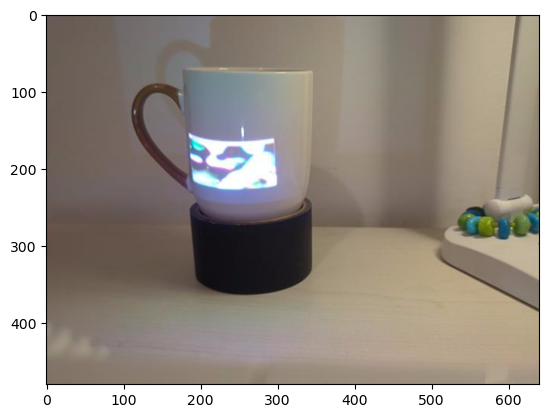

In [63]:
plt.imshow(frames_patchs[10])

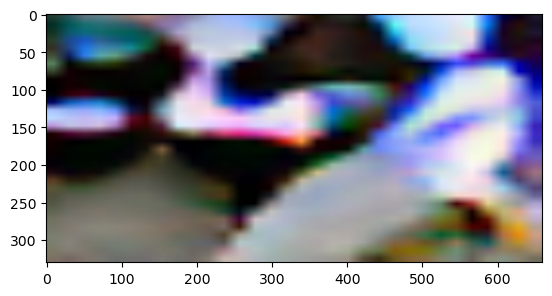

In [64]:
plt.imshow(adv_patchs[10])

C:\Users\danny\AppData\Local\Temp\ipykernel_16724\1535359889.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_masked = unwarped_frame * torch.tensor(img_section_mask)


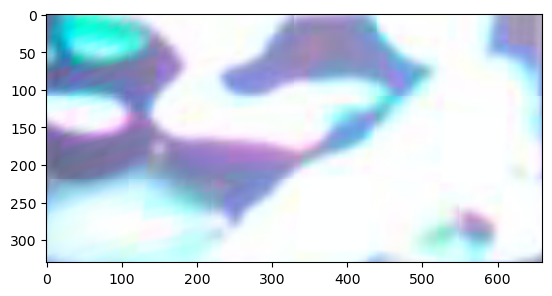

In [65]:
plt.imshow(unwarp2(tt(frames_patchs[10]).unsqueeze(0))[0].permute(1,2,0).numpy())

In [66]:
frames_patchs[0].shape

(480, 640, 3)

In [72]:
# unwrapped_frames = []
with torch.no_grad():
    for i,frame in tqdm.tqdm_notebook(enumerate(frames_patchs)):
        frame_tensor = torch.tensor(frame).permute(2,0,1).float().cpu().unsqueeze(0) / 255
        unwrapped_frame = unwarp2(frame_tensor).squeeze(0).cpu()
        # unwrapped_frames.append(unwrapped_frame)

        unwrapped_frame = unwrapped_frame.cpu().numpy().transpose(1,2,0)
        unwrapped_frame = (unwrapped_frame * 255).astype(np.uint8)
        unwrapped_frame = cv2.cvtColor(unwrapped_frame, cv2.COLOR_RGB2BGR)
        cv2.imwrite(f'botorch_snapshots//unwrapped_frame_mug_27_4_{i}.jpg',unwrapped_frame)

C:\Users\danny\AppData\Local\Temp\ipykernel_16724\1560263256.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,frame in tqdm.tqdm_notebook(enumerate(frames_patchs)):


0it [00:00, ?it/s]

C:\Users\danny\AppData\Local\Temp\ipykernel_16724\1535359889.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_masked = unwarped_frame * torch.tensor(img_section_mask)


C:\Users\danny\AppData\Local\Temp\ipykernel_16724\1020130507.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_masked = img_t * torch.tensor(img_section_mask).unsqueeze(0).unsqueeze(0).double()


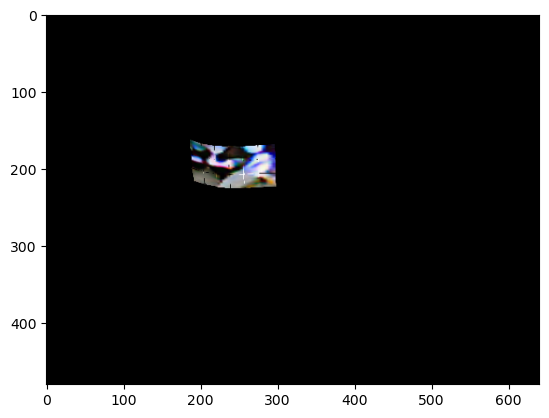

In [69]:
plt.imshow(warp2(tt(adv_patchs[10]).unsqueeze(0))[0].permute(1,2,0).numpy())

In [ ]:

unwarped_patchs = []
for i, (start_x, start_y, end_x, end_y) in enumerate(sections):

    img_frame = tt(frames_patchs[1]).unsqueeze(0).double()

    unwarped_frame = kornia.geometry.transform.warp_perspective(img_frame, H_t[i].inverse().unsqueeze(0), (330, 660))


    img_section_mask = np.zeros( (330, 660))
    img_section_mask[start_y+buffer:end_y-buffer, start_x+buffer:end_x-buffer] = 1
    # img_section_mask[start_y:end_y, start_x:end_x] = 1

    img_masked = unwarped_frame * torch.tensor(img_section_mask).unsqueeze(0).unsqueeze(0).double()


    unwarped_patchs.append(img_masked.squeeze(0).permute(1,2,0).cpu().numpy())

## Transforms

In [328]:
import matplotlib.pyplot as plt
import numpy as np

import skimage as ski


In [329]:
import  skimage.transform  as skit

In [330]:
new_points.shape

(2173, 2)

In [331]:
# src = np.array(original_points).astype(np.float32)
# dst = np.array(new_points_clear).astype(np.float32)

# slack = 2
# src_clear = src[ (np.abs(new_points[:,0]-mean_x)<slack*std_x) & (np.abs(new_points[:,1]-mean_y)<slack*std_y) ]
# dst_clear = dst[ (np.abs(new_points[:,0]-mean_x)<slack*std_x) & (np.abs(new_points[:,1]-mean_y)<slack*std_y) ]

image = frames[10].copy()

tps = skit.ThinPlateSplineTransform()
tps.estimate(original_points, new_points_clear)


True

In [332]:
new_points[748]

array([222, 214])

In [333]:
cord_map = np.zeros((660,330,2))

In [334]:
src = original_points.astype(np.int32)
dst = new_points_clear.astype(np.int32)

In [348]:
from xml.etree.ElementInclude import include
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor

# 1. Expand X with polynomial features
poly = PolynomialFeatures(2, include_bias=True)
X_poly = poly.fit_transform(src)

# 2. Fit a regression model for both outputs
model = MultiOutputRegressor(Ridge(alpha=1.0))
model.fit(X_poly, dst)


# Now you can predict!
Y_pred = model.predict(X_poly)

d_grid = np.mgrid[0:660, 0:330].reshape(2, -1).T
X_poly_grid = poly.transform(d_grid)
Y_pred_grid = model.predict(X_poly_grid)
Y_pred_grid = Y_pred_grid.reshape(660, 330, 2)
Y_pred_grid = Y_pred_grid.astype(np.int32)

zero_mask = np.zeros_like(frame)
for i in range(Y_pred_grid.shape[0]):
    for j in range(Y_pred_grid.shape[1]):
        value = adv_patch[j,i,:]
        new_x = Y_pred_grid[i,j,0]
        new_y = Y_pred_grid[i,j,1]
        if new_x == new_x and new_y == new_y:
            zero_mask[int(new_y),int(new_x),:] = value


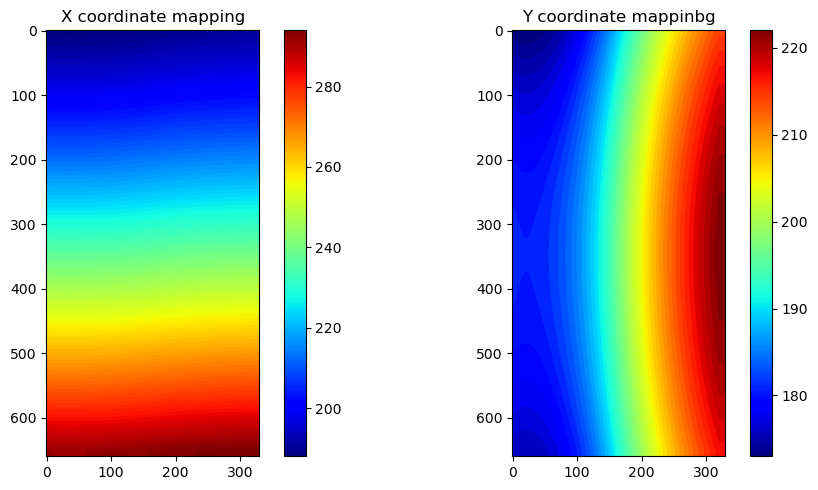

In [598]:

import numpy as np
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor

spline = SplineTransformer(degree=2, n_knots=3, include_bias=True)
X_spline = spline.fit_transform(src)

# 2. Fit a regression model for both outputs
model = MultiOutputRegressor(Ridge(alpha=1.0))
model.fit(X_spline, dst)
Y_pred = model.predict(X_spline)

d_grid = np.mgrid[0:660, 0:330].reshape(2, -1).T
X_spline_grid = spline.transform(d_grid)
Y_pred_grid = model.predict(X_spline_grid)
Y_pred_grid = Y_pred_grid.reshape(660, 330, 2)
Y_pred_grid = Y_pred_grid.astype(np.int32)

zero_mask = np.zeros_like(frame)
for i in range(Y_pred_grid.shape[0]):
    for j in range(Y_pred_grid.shape[1]):

        if i > src[:,0].max() or j > src[:,1].max():
            continue
        if i < src[:,0].min() or j < src[:,1].min():
            continue
        value = adv_patch[j,i,:]
        new_x = Y_pred_grid[i,j,0]
        new_y = Y_pred_grid[i,j,1]
        if new_x > dst[:,0].max() or new_y > dst[:,1].max():
            continue
        if new_x < dst[:,0].min() or new_y < dst[:,1].min():
            continue
        
        if new_x == new_x and new_y == new_y:
            zero_mask[int(new_y),int(new_x),:] = value

# Predict
# Y_new_pred_rbf = rbf_model(X_new)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(Y_pred_grid[:, :, 0], cmap='jet')
plt.colorbar()
plt.title('X coordinate mapping')

plt.subplot(1, 2, 2)
plt.imshow(Y_pred_grid[:, :, 1], cmap='jet')
plt.colorbar()
plt.title('Y coordinate mappinbg')
plt.tight_layout()
plt.show()

In [463]:
import kornia
from kornia.geometry.transform import get_tps_transform, warp_image_tps, warp_points_tps
import torch

In [396]:
torch.tensor(src).unsqueeze(0).shape

torch.Size([1, 2172, 2])

In [535]:
points_src = torch.rand(1, 5, 2)

points_dst = torch.rand(1, 5, 2)

kernel_weights, affine_weights = get_tps_transform(points_src, points_dst)

warped = warp_points_tps(points_src, points_dst, kernel_weights, affine_weights)

warped_correct = torch.allclose(warped, points_dst)

In [460]:
image = adv_patchs[10].copy()

In [561]:
warped_image = warp_image_tps(tt(image).unsqueeze(0),points_dst, kernel_weights, affine_weights)

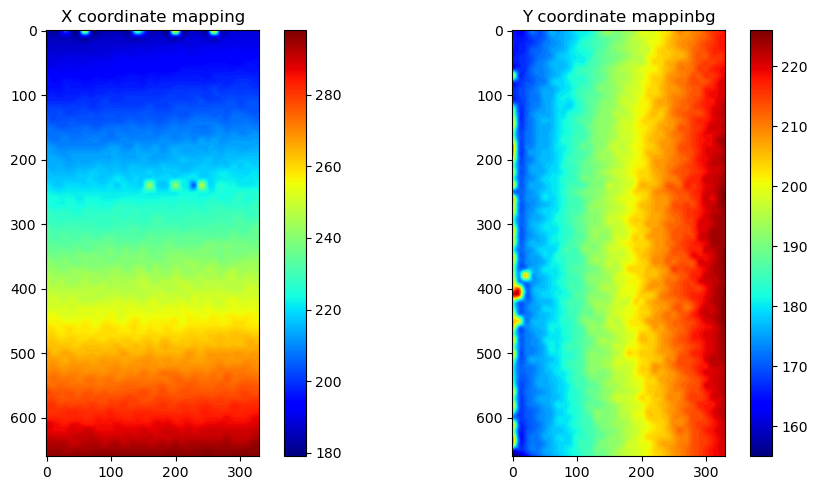

In [611]:
from scipy.interpolate import RBFInterpolator

# rbf_model = RBFInterpolator(src, dst, neighbors=50, smoothing=2.0)  
rbf_model = RBFInterpolator(src, dst, kernel='thin_plate_spline', smoothing=10.0)  # Adjust smoothing parameter as needed
d_grid = np.mgrid[0:660, 0:330].reshape(2, -1).T

Y_pred_grid = rbf_model(d_grid)
Y_pred_grid = Y_pred_grid.reshape(660, 330, 2)
Y_pred_grid = Y_pred_grid.astype(np.int32)


zero_mask = np.zeros_like(frame)
for i in range(Y_pred_grid.shape[0]):
    for j in range(Y_pred_grid.shape[1]):

        # if i > src[:,0].max() or j > src[:,1].max():
        #     continue
        # if i < src[:,0].min() or j < src[:,1].min():
        #     continue
        value = adv_patch[j,i,:]
        new_x = Y_pred_grid[i,j,0]
        new_y = Y_pred_grid[i,j,1]
        # if new_x > dst[:,0].max() or new_y > dst[:,1].max():
        #     continue
        # if new_x < dst[:,0].min() or new_y < dst[:,1].min():
        #     continue
        if new_x > 660 or new_y > 330:
            continue
        if new_x < 0 or new_y < 0:
            continue

        
        if new_x == new_x and new_y == new_y:
            zero_mask[int(new_y),int(new_x),:] = value
# Predict
# Y_new_pred_rbf = rbf_model(X_new)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(Y_pred_grid[:, :, 0], cmap='jet')
plt.colorbar()
plt.title('X coordinate mapping')

plt.subplot(1, 2, 2)
plt.imshow(Y_pred_grid[:, :, 1], cmap='jet')
plt.colorbar()
plt.title('Y coordinate mappinbg')
plt.tight_layout()
plt.show()

In [613]:

zero_mask = np.zeros_like(adv_patchs[10])
for i in range(Y_pred_grid.shape[0]):
    for j in range(Y_pred_grid.shape[1]):

        if i > src[:,0].max() or j > src[:,1].max():
            continue
        if i < src[:,0].min() or j < src[:,1].min():
            continue
        # value = adv_patch[j,i,:]
        new_x = Y_pred_grid[i,j,0]
        new_y = Y_pred_grid[i,j,1]
        if new_x > dst[:,0].max() or new_y > dst[:,1].max():
            continue
        if new_x < dst[:,0].min() or new_y < dst[:,1].min():
            continue

        
        if new_x == new_x and new_y == new_y:
            zero_mask[j,i,:] = frames_patchs[10][new_y,new_x,:]
            # zero_mask[int(new_y),int(new_x),:] = value

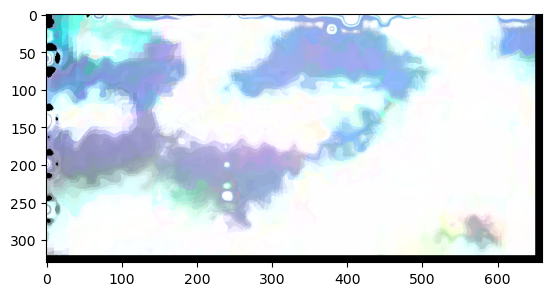

In [614]:
plt.imshow(zero_mask)

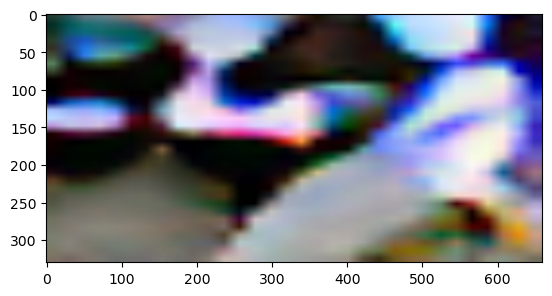

In [592]:
plt.imshow(adv_patchs[10])

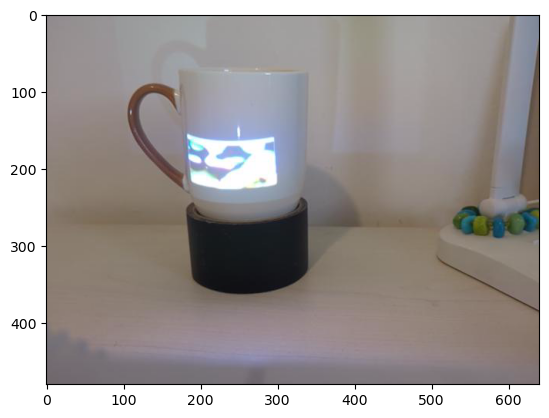

In [583]:
plt.imshow(frames_patchs[10])

In [ ]:
from scipy.interpolate import RBFInterpolator

# Thin plate spline kernel = 'thin_plate_spline'
tps_model = RBFInterpolator(X, Y, kernel='thin_plate_spline', smoothing=1.0)

In [427]:
for s,d in zip(src,dst):
    cord_map[s[0],s[1],:] = d


In [342]:
cord_map = np.zeros((660, 330, 2))
for s,d in zip(src,dst):
    cord_map[s[0],s[1],:] = d

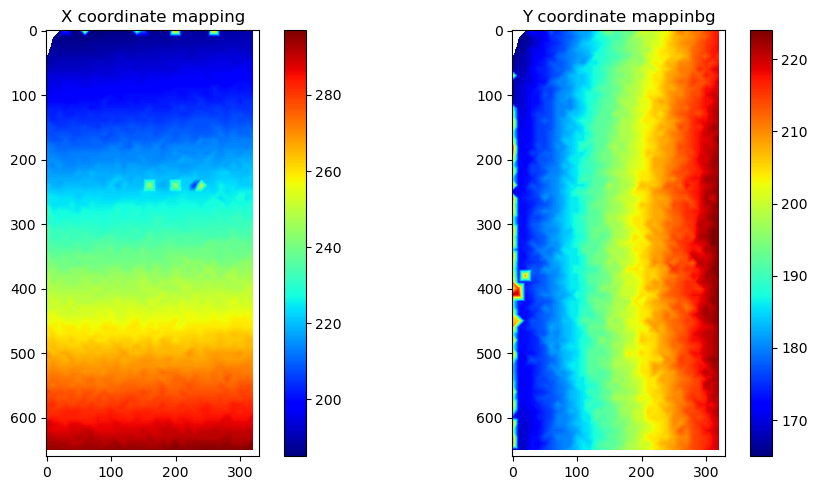

In [350]:
from scipy.interpolate import griddata

cord_map = np.zeros((660, 330, 2))
for s,d in zip(src,dst):
    cord_map[s[0],s[1],:] = d


# Identify the non-zero entries in cord_map
non_zero_indices = np.where(np.any(cord_map != 0, axis=2))
non_zero_points = np.column_stack(non_zero_indices)
non_zero_values = cord_map[non_zero_indices]

# Create a grid of all coordinates
grid_y, grid_x = np.mgrid[0:cord_map.shape[0], 0:cord_map.shape[1]]
grid_points = np.column_stack([grid_y.ravel(), grid_x.ravel()])

# Interpolate for x and y coordinates
interp_x = griddata(non_zero_points, non_zero_values[:, 0], grid_points, method='linear')
interp_y = griddata(non_zero_points, non_zero_values[:, 1], grid_points, method='linear')

# Reshape and update cord_map
interp_x = interp_x.reshape(cord_map.shape[0], cord_map.shape[1])
interp_y = interp_y.reshape(cord_map.shape[0], cord_map.shape[1])


cord_map[:, :, 0] = interp_x
cord_map[:, :, 1] = interp_y

# Visualize the interpolated mapping
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cord_map[:, :, 0], cmap='jet')
plt.colorbar()
plt.title('X coordinate mapping')

plt.subplot(1, 2, 2)
plt.imshow(cord_map[:, :, 1], cmap='jet')
plt.colorbar()
plt.title('Y coordinate mappinbg')
plt.tight_layout()
plt.show()

In [351]:
zero_mask = np.zeros_like(frame)
for i in range(cord_map.shape[0]):
    for j in range(cord_map.shape[1]):
        value = adv_patch[j,i,:]
        new_x = cord_map[i,j,0]
        new_y = cord_map[i,j,1]
        if new_x == new_x and new_y == new_y and (new_x != 0 and new_y != 0):
            zero_mask[int(new_y),int(new_x),:] = value

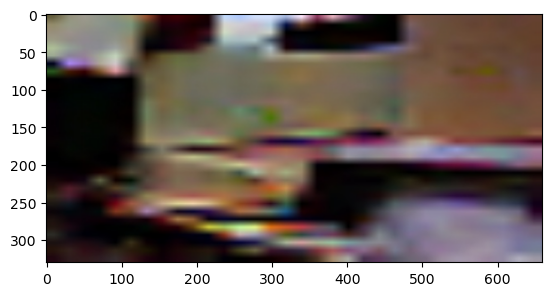

In [352]:
plt.imshow(adv_patch)

In [609]:
s = (tt(orig_ref_frame_for_saving)+tt(zero_mask))
plt.imshow(s.permute(1,2,0).numpy())


RuntimeError: The size of tensor a (640) must match the size of tensor b (660) at non-singleton dimension 2

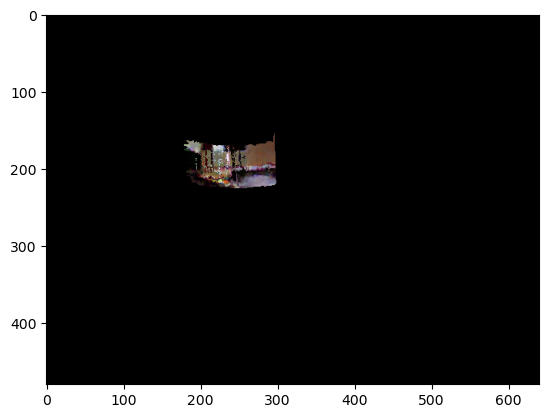

In [612]:
plt.imshow(zero_mask)

In [146]:
dst[748]

array([-51., 644.], dtype=float32)

In [145]:
src[748]

array([240,  30])

In [142]:
(i,j)

(240, 30)

In [130]:
src

array([[  0,  20],
       [  0,  30],
       [  0,  40],
       ...,
       [640, 290],
       [640, 300],
       [640, 310]])

array([nan, nan])

In [90]:
cord_map.shape

(660, 330, 2)

In [ ]:
warped = ski.transform.warp(image, tps)

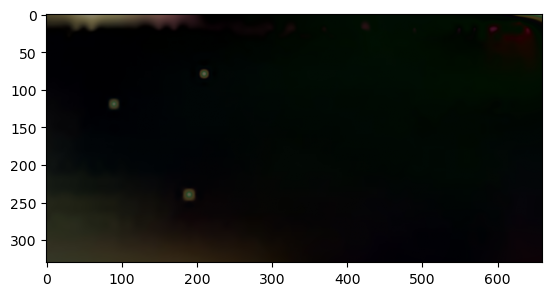

In [55]:
plt.imshow(warped)